In [1]:
import os

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
try:
    import open3d as o3d
except ImportError:
    import sys
    print(sys.exc_info())
import pandas as pd

from dosipy.utils.dataloader import load_ear_data
from dosipy.utils.integrate import elementwise_quad, elementwise_dblquad
from dosipy.utils.viz import (set_colorblind, save_fig, scatter_2d, scatter_3d,
                              fig_config)
from helpers import (clean_df, export_pcd, export_fields,
                     poynting_vector, get_imcolors, export_rect_idx)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [109]:
polarization = 'te'
f = 26

# Spatial-average APD

In [63]:
df = load_ear_data(polarization, f, surface='front')
df = clean_df(df)
xyz = export_pcd(df)
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(xyz)
center = pcd.get_center()
# cframe = o3d.geometry.TriangleMesh.create_coordinate_frame(
#     size=9, origin=center+np.array([6, -25, -20])
# )
# o3d.visualization.draw_geometries([pcd, cframe])

In [64]:
E, H = export_fields(df)
Sx, Sy, Sz = poynting_vector(E, H)

pcd.estimate_normals()
n = np.asarray(pcd.normals)

APD = abs(Sx.real * n[:, 0] + Sy.real * n[:, 1] + Sz.real * n[:, 2])

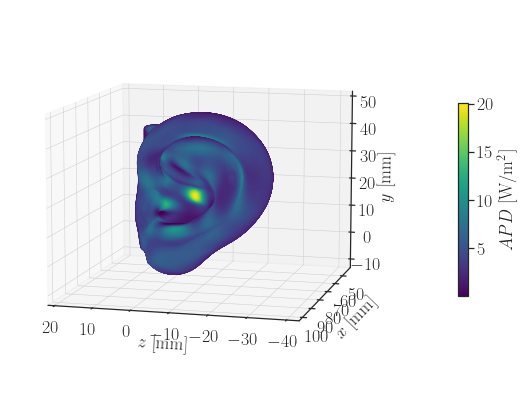

In [65]:
set_colorblind()
fig_config(latex=True, scaler=2, text_size=18)
label = '$APD$ [W/m$^2$]'
fig, ax = scatter_3d({'$z$ [mm]': xyz[:, 2],
                      '$x$ [mm]': xyz[:, 0],
                      '$y$ [mm]': xyz[:, 1],
                      label: APD},
                     elev=[10], azim=[105])

In [93]:
diameter = np.linalg.norm(
    pcd.get_max_bound() - pcd.get_min_bound()
)
radius = 10 ** 5
camera = [center[0] + diameter, center[1], center[2]]
_, mask = pcd.hidden_point_removal(camera, radius)
xyz_zy = xyz[mask]
APD_zy = APD[mask]

In [94]:
avg_center_idx = np.where(APD_zy == APD_zy.max())[0][0]
avg_center = xyz_zy[avg_center_idx][2], xyz_zy[avg_center_idx][1]
edge_length = 20
area = edge_length ** 2
origin, idx_rect = export_rect_idx(xyz=xyz_zy,
                                   center=avg_center,
                                   edge_length=edge_length,
                                   view='zy')
xyz_rect = xyz_zy[idx_rect]
APD_rect = APD_zy[idx_rect]

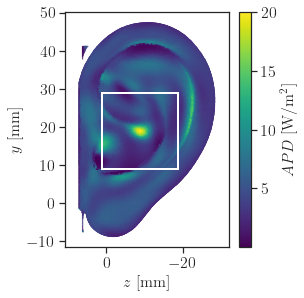

In [95]:
set_colorblind()
fig_config(latex=True, scaler=1.5, text_size=16)
fig, ax = scatter_2d({'$z$ [mm]': xyz_zy[:, 2],
                      '$y$ [mm]': xyz_zy[:, 1],
                      label: APD_zy}, s=0.1, figsize=(2.950 * 1.5, 2.950 * 1.5))
patch_rect = Rectangle(origin, edge_length, edge_length, fc='None', lw=2)
ax.add_patch(patch_rect)
ax.invert_xaxis()

In [101]:
ds = 10
APD_av = elementwise_dblquad(points=np.c_[xyz_rect[::ds, 2], xyz_rect[::ds, 1]],
                             values=APD_rect[::ds], degree=11) / area
APD_av

4.645703948609047

# Spatial-average TPD

In [110]:
# this should be optimized for large files, upload only the averaging volume

fname = os.path.join('data',
                     f'loss_3D_ear_{f}GHz_{polarization.upper()}_front.txt')
df = (pd.read_csv(fname, names=['x [mm]', 'y [mm]', 'z [mm]', 'Pl [W/m^3]'],
                  header=None, delim_whitespace=True, skiprows=[0, 1])
      [lambda x: x['Pl [W/m^3]'] != 0.0])
df.reset_index(drop=True, inplace=True)

In [112]:
xyz = export_pcd(df)
Pl = df['Pl [W/m^3]'].to_numpy()
# pcd = o3d.geometry.PointCloud()
# pcd.points = o3d.utility.Vector3dVector(xyz)
# center = pcd.get_center()
# cframe = o3d.geometry.TriangleMesh.create_coordinate_frame(
#    size=9, origin=center+np.array([6, -25, -20])
# )
# o3d.visualization.draw_geometries([pcd_t, cframe])

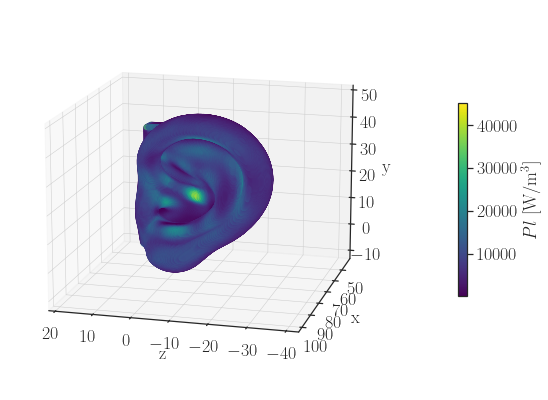

In [114]:
set_colorblind()
fig_config(latex=True, scaler=2, text_size=18)
label = '$Pl$ [W/m$^3$]'
fig, ax = scatter_3d({'z': xyz[:, 2],
                      'x': xyz[:, 0],
                      'y': xyz[:, 1],
                      label: Pl},
                      elev=[15], azim=[105])

In [115]:
_, mask = export_rect_idx(xyz,
                          center=avg_center,
                          edge_length=edge_length,
                          view='zy')
xyz_rect = xyz_t[mask]
Pl_rect = Pl[mask]

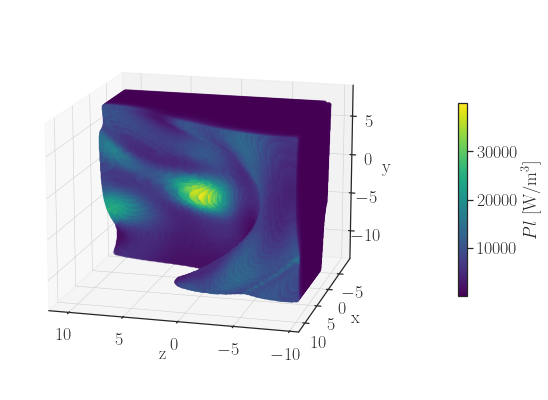

In [116]:
set_colorblind()
fig_config(latex=True, scaler=2, text_size=18)
fig, ax = scatter_3d({'z': xyz_rect[:, 2],
                      'x': xyz_rect[:, 0],
                      'y': xyz_rect[:, 1],
                      label: Pl_rect},
                      elev=[15], azim=[105])

In [117]:
df_rect = pd.DataFrame(np.c_[xyz_rect, Pl_rect],
                       columns = ['x','y' ,'z', 'Pl'])
df_rect_interm = df_rect.groupby(['y', 'z']).apply(
    lambda col: elementwise_quad(col.x.to_numpy() / 1000,  # convert to meters
                                 col.Pl.to_numpy(),
                                 degree=11)
).reset_index()
yz_rect = np.c_[df_rect_interm[['y', 'z']].to_numpy()]
TPD_rect = df_rect_interm[0].to_numpy()

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


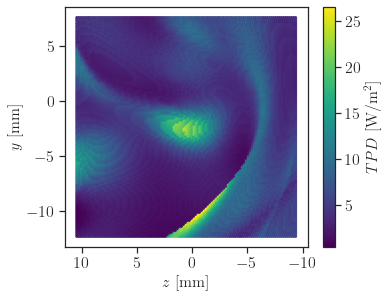

In [118]:
set_colorblind()
fig_config(latex=True, scaler=1.5, text_size=16)
label = '$TPD$ [W/m$^2$]'
fig, ax = scatter_2d({'$z$ [mm]': yz_rect[:, 1],
                      '$y$ [mm]': yz_rect[:, 0],
                      label: TPD_rect}, s=5,
                     figsize=(2.950 * 1.915, 2.950 * 1.5))
ax.invert_xaxis()

In [119]:
TPD_av = elementwise_dblquad(points=np.c_[yz_rect[:, 1], yz_rect[:, 0]],
                             values=TPD_rect, degree=11) / area
TPD_av

5.53153189718316